## ANALYSIS PIPELINE OF RA DATA

In [1]:
suppressMessages({library(Seurat)
                  library(ggrepel)
                  library(tidyverse)
                  library(ggplot2)
                  library(ggpubr)
                  library(dplyr)
                  library(patchwork)
                  library(RColorBrewer)
                  library(reshape2)
                  library(scales)
                  library(ggplotify)
                  library(viridis)
                  library(tidydr)
                  library(cols4all)
                  # library(GEB)
                  library(scRNAtoolVis) # 为了使用数据
                  library(cowplot) # plot_grid
                  library(ComplexHeatmap)
    library(circlize)
                  library(Matrix)})

source("/Users/Aking/Nutstore Files/我的坚果云//博后//代码//scgene_test.R")


# mycol <- c("#7F3C8D", "#11A579", "#3969AC" ,"#F2B701" ,"#E73F74", "#80BA5A", "#E68310", "#008695", "#A5AA99")
# mycol <- c("#66C5CC" ,"#F6CF71", "#F89C74", "#DCB0F2" ,"#87C55F" ,"#9EB9F3" ,"#FE88B1" ,"#C9DB74", "#8BE0A4")
# mycol <- c("#4E79A7", "#F28E2B", "#E15759", "#76B7B2", "#59A14F", "#EDC948", "#B07AA1", "#FF9DA7", "#9C755F","#8BE0A4")
# mycol <- c("#4E79A7", "#A0CBE8" , "#F28E2B" ,"#FFBE7D" ,"#59A14F", "#8CD17D", "#B6992D", "#F1CE63", "#499894","#9C755F")
 mycol <- brewer.pal(12, "Paired")

cell_type_cols <- c("#20B2AA","#FF34B3","#00F5FF","#ADFF2F","#FFA500","#BC8F8F","#FF6A6A","#7FFFD4",brewer.pal(9, "Set1"),
                    "#AB82FF","#90EE90","#00CD00","#008B8B","#6495ED","#FFC1C1","#CD5C5C","#8B008B",
                    "#FF3030","#7CFC00","#000000","#708090","#C71585", "#EEE9E9","#9400D3","#D8BFD8")

## Load the mouse dataset of rds

In [2]:
seurat_integrated <- readRDS("seurat_integrated.rds")

In [4]:
seurat_integrated

An object of class Seurat 
21192 features across 72212 samples within 2 assays 
Active assay: RNA (18192 features, 0 variable features)
 2 layers present: counts, data
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

In [19]:
seurat_integrated.markers <- readRDS("seurat_integrated.markers_202212.rds")

## Plots

In [ ]:
options(repr.plot.width = 12, repr.plot.height=5)
p1 <- FeaturePlot(object = seurat_integrated,
           features = "nFeature_RNA",
            cols = c("GhostWhite","IndianRed"),
            pt.size=0.5)

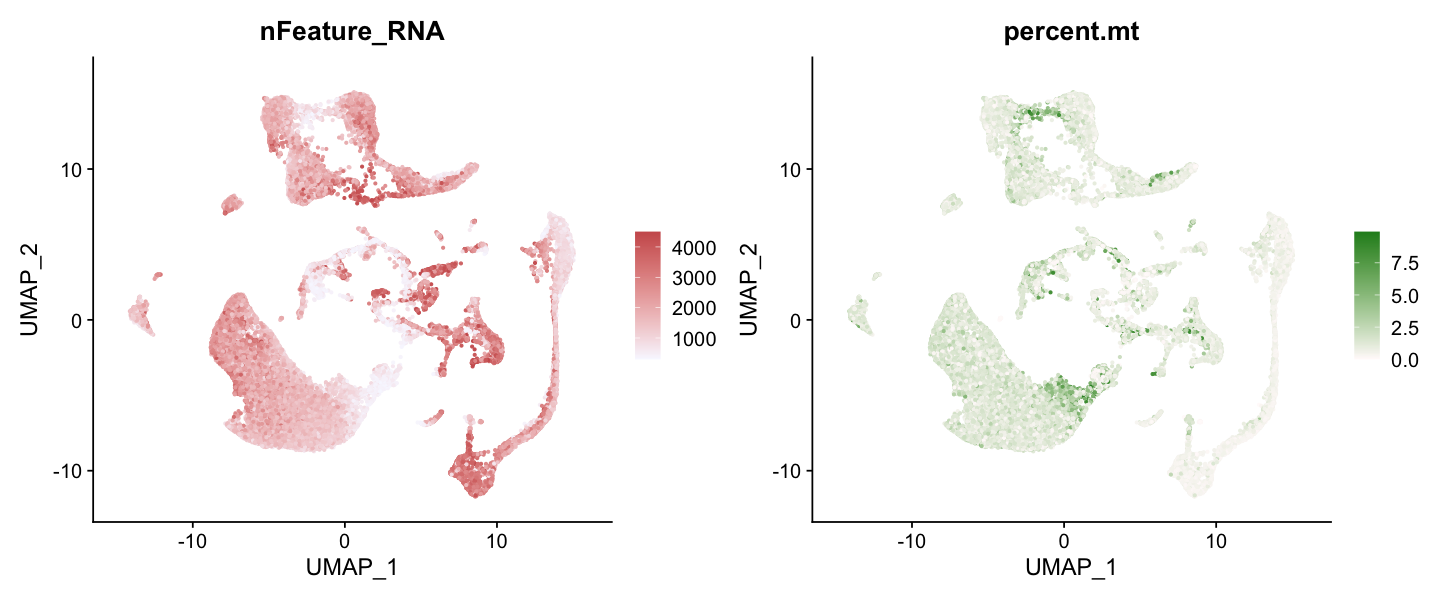

In [6]:
options(repr.plot.width = 12, repr.plot.height=5)
p1 <- FeaturePlot(object = seurat_integrated,
           features = "nFeature_RNA",
            cols = c("GhostWhite","IndianRed"),
            pt.size=0.5)

p2 <- FeaturePlot(object = seurat_integrated,
           features = "percent.mt",
            cols = c("Snow","ForestGreen"),
            pt.size=0.5)

p1 | p2

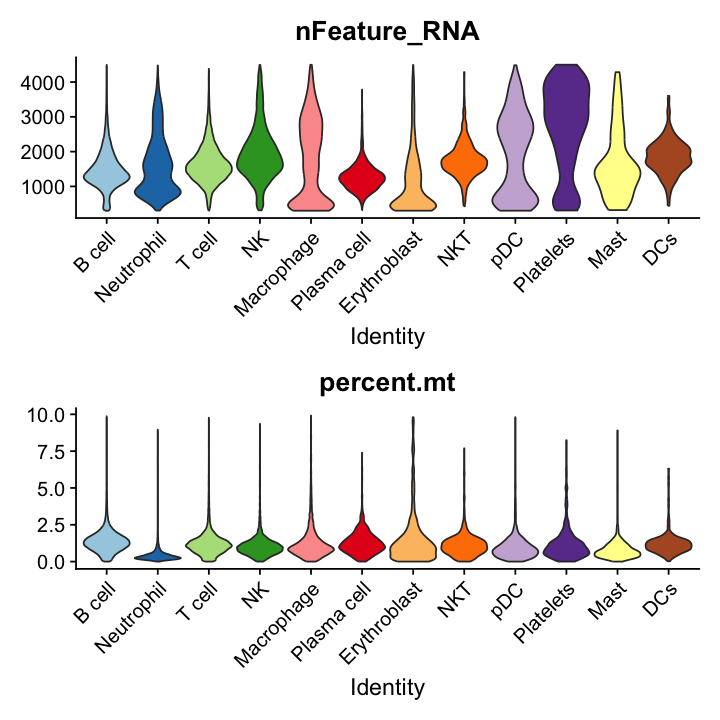

In [157]:
options(repr.plot.height=6,repr.plot.width=6)
VlnPlot(seurat_integrated, group.by = 'Cell_Type_03', ncol = 1,
        cols = mycol,
        pt.size = 0, 
        features = c("nFeature_RNA","percent.mt"))

### Customazied UMAP

In [7]:
#UMAP提取方法相同：
UMAP <- as.data.frame(seurat_integrated@reductions$umap@cell.embeddings)

##提取组别信息
Idents(seurat_integrated) <- "group"
mygroup <- Idents(seurat_integrated)

##提取亚群注释信息：
Idents(seurat_integrated) <- "seurat_clusters"
myclusters <- Idents(seurat_integrated)

##提取亚群注释信息：
Idents(seurat_integrated) <- "Cell_Type_03"
celltype <- Idents(seurat_integrated)
# table(celltype)


## 合并数据框
UMAP <- cbind(UMAP,celltype, mygroup, myclusters)
head(UMAP,3)

#在图中增加亚群标签:
##计算每个亚群散点的中位数，作为图中标签的坐标
label <- UMAP %>%
  group_by(celltype)%>%
  summarise(UMAP_1 = median(UMAP_1), UMAP_2 = median(UMAP_2))
# head(label,2)

,UMAP_1,UMAP_2,celltype,mygroup,myclusters
,<dbl>,<dbl>,<fct>,<fct>,<fct>
AAACCTGAGACGCAAC-1_1,6.516676,9.014648,NK,AgTCV,7
AAACCTGAGCCACCTG-1_1,13.670430,-3.446817,Neutrophil,AgTCV,6
AAACCTGAGCGTGAAC-1_1,-7.235449,-2.526585,B cell,AgTCV,1


#### cell_type

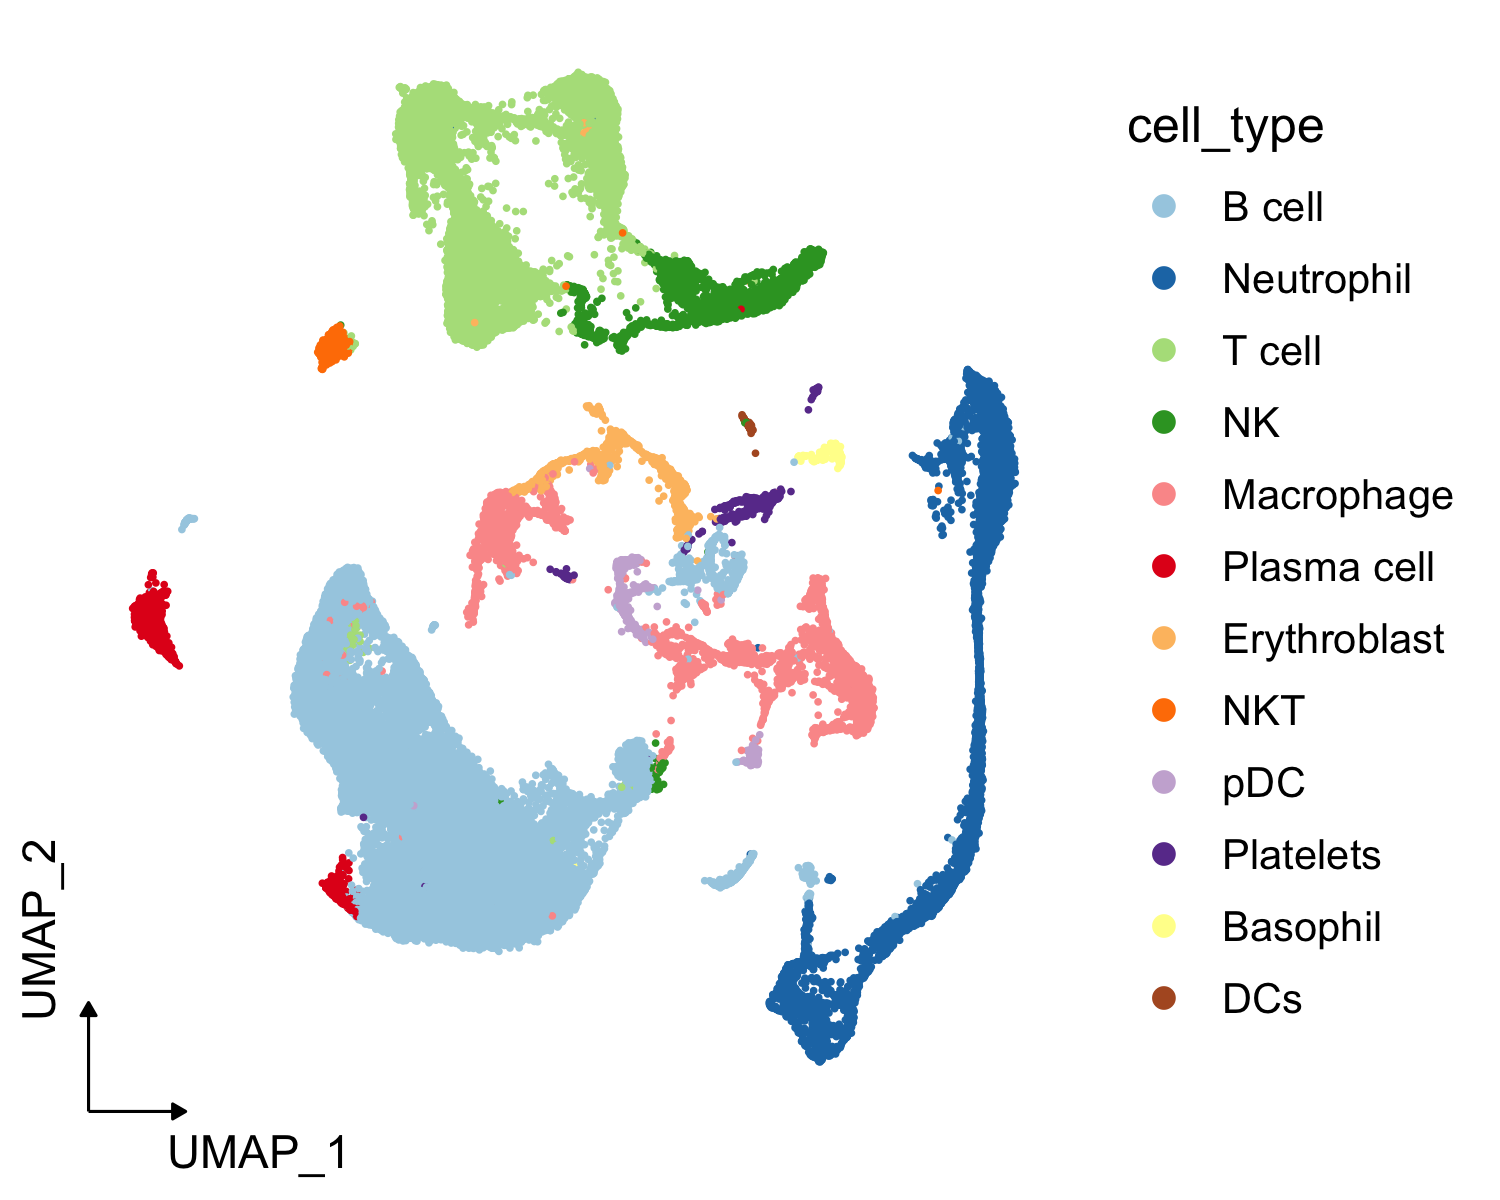

In [60]:
options(repr.plot.width=5,repr.plot.height=4, repr.plot.res=300)
#建立自定义主题：
mytheme <- theme_void() + #空白主题，便于我们后期添加UMAP箭头
  theme(plot.margin = margin(5.5,15,5.5,5.5)) #画布空白页缘调整

#建立映射，添加散点：
p <- ggplot(data = UMAP, aes(x = UMAP_1, y = UMAP_2)) +
  geom_point(aes(color = celltype),
             size = 0.2,
             alpha = 1)+
  # stat_ellipse(aes(color = celltype),
  #              level = 0.95, linetype = 1, show.legend = F) +
  # stat_ellipse(aes(color = celltype),
  #              level = 0.95, linetype = 2, show.legend = F) +
  
  # stat_ellipse(aes(color = celltype, fill = celltype),
  #              level = 0.95, linetype = 1, show.legend = F,
  #              geom = 'polygon', alpha = 0.1) + mytheme + 
  # geom_text(data = label,
  #           aes(x = UMAP_1, y = UMAP_2, label = celltype),
  #         #  fontface = "bold", #粗体强调
  #           color = 'black', size = 5) +
  guides(color = guide_legend(override.aes = list(size = 2),title = 'cell_type')) + 
  scale_color_manual(values = mycol) +   
# scale_fill_manual(values = rev(mycol)) +

  theme_dr(xlength = 0.1, #x轴长度
           ylength = 0.1, #y轴长度
           arrow = grid::arrow(length = unit(0.05, "inches"), #箭头大小/长度
                               ends = 'last', type = "closed")) + #箭头描述信息
  theme(panel.grid = element_blank(),
        legend.text = element_text(size=10),legend.title = element_text(size = 12))
  
p

#### group

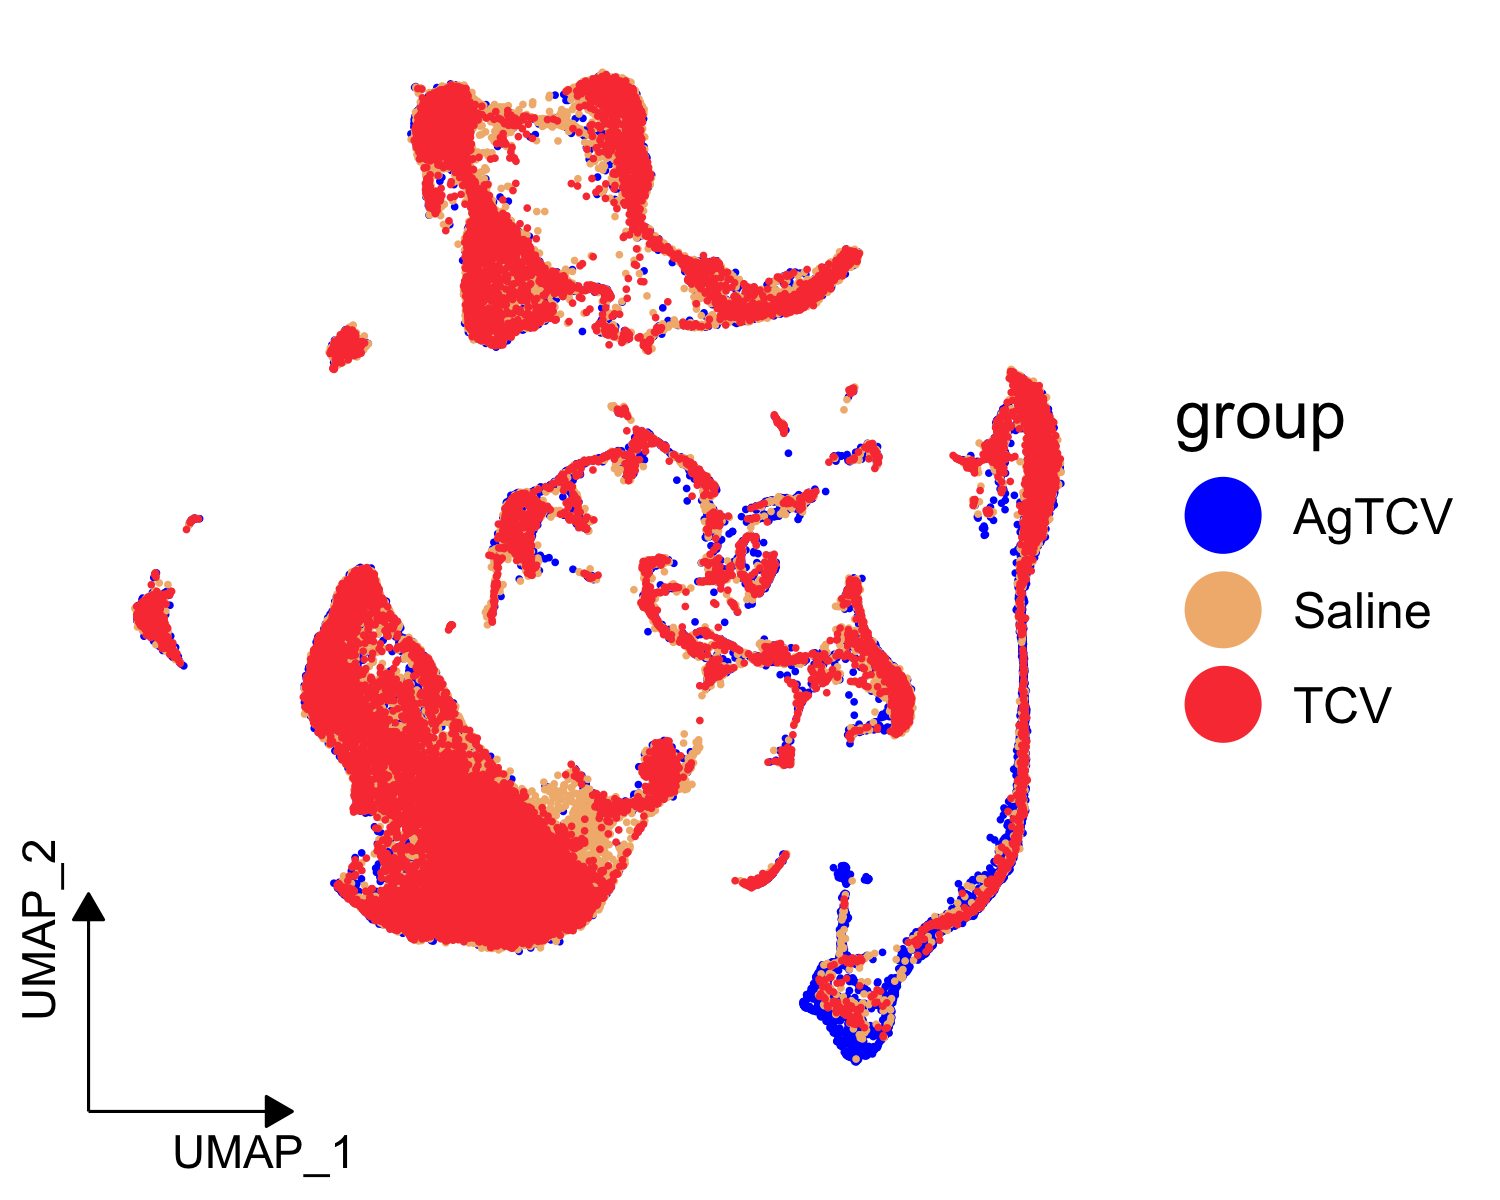

In [34]:
options(repr.plot.width=5,repr.plot.height=4)
#建立自定义主题：
mytheme <- theme_void() + #空白主题，便于我们后期添加UMAP箭头
  theme(plot.margin = margin(5.5,15,5.5,5.5)) #画布空白页缘调整

#建立映射，添加散点：
p <- ggplot(data = UMAP, aes(x = UMAP_1, y = UMAP_2)) +
  geom_point(aes(color = mygroup),
             size = 0.2,
             alpha = 1.0)+
  # stat_ellipse(aes(color = celltype),
  #              level = 0.95, linetype = 1, show.legend = F) +
  # stat_ellipse(aes(color = celltype),
  #              level = 0.95, linetype = 2, show.legend = F) +
  
  # stat_ellipse(aes(color = celltype, fill = celltype),
  #              level = 0.95, linetype = 1, show.legend = F,
  #              geom = 'polygon', alpha = 0.1) + mytheme + 
  # geom_text(data = label,
  #           aes(x = UMAP_1, y = UMAP_2, label = celltype),
  #         #  fontface = "bold", #粗体强调
  #           color = 'black', size = 5) +
  guides(color = guide_legend(override.aes = list(size = 8),title = 'group')) + 
 scale_color_manual(values = group_col_4) +   
# scale_fill_manual(values = group_col_4) +

  theme_dr(xlength = 0.2, #x轴长度
           ylength = 0.2, #y轴长度
           arrow = grid::arrow(length = unit(0.1, "inches"), #箭头大小/长度
                               ends = 'last', type = "closed")) + #箭头描述信息
  theme(panel.grid = element_blank(),
        legend.text = element_text(size=12),legend.title = element_text(size = 16))
  
p

### Customazied histogram

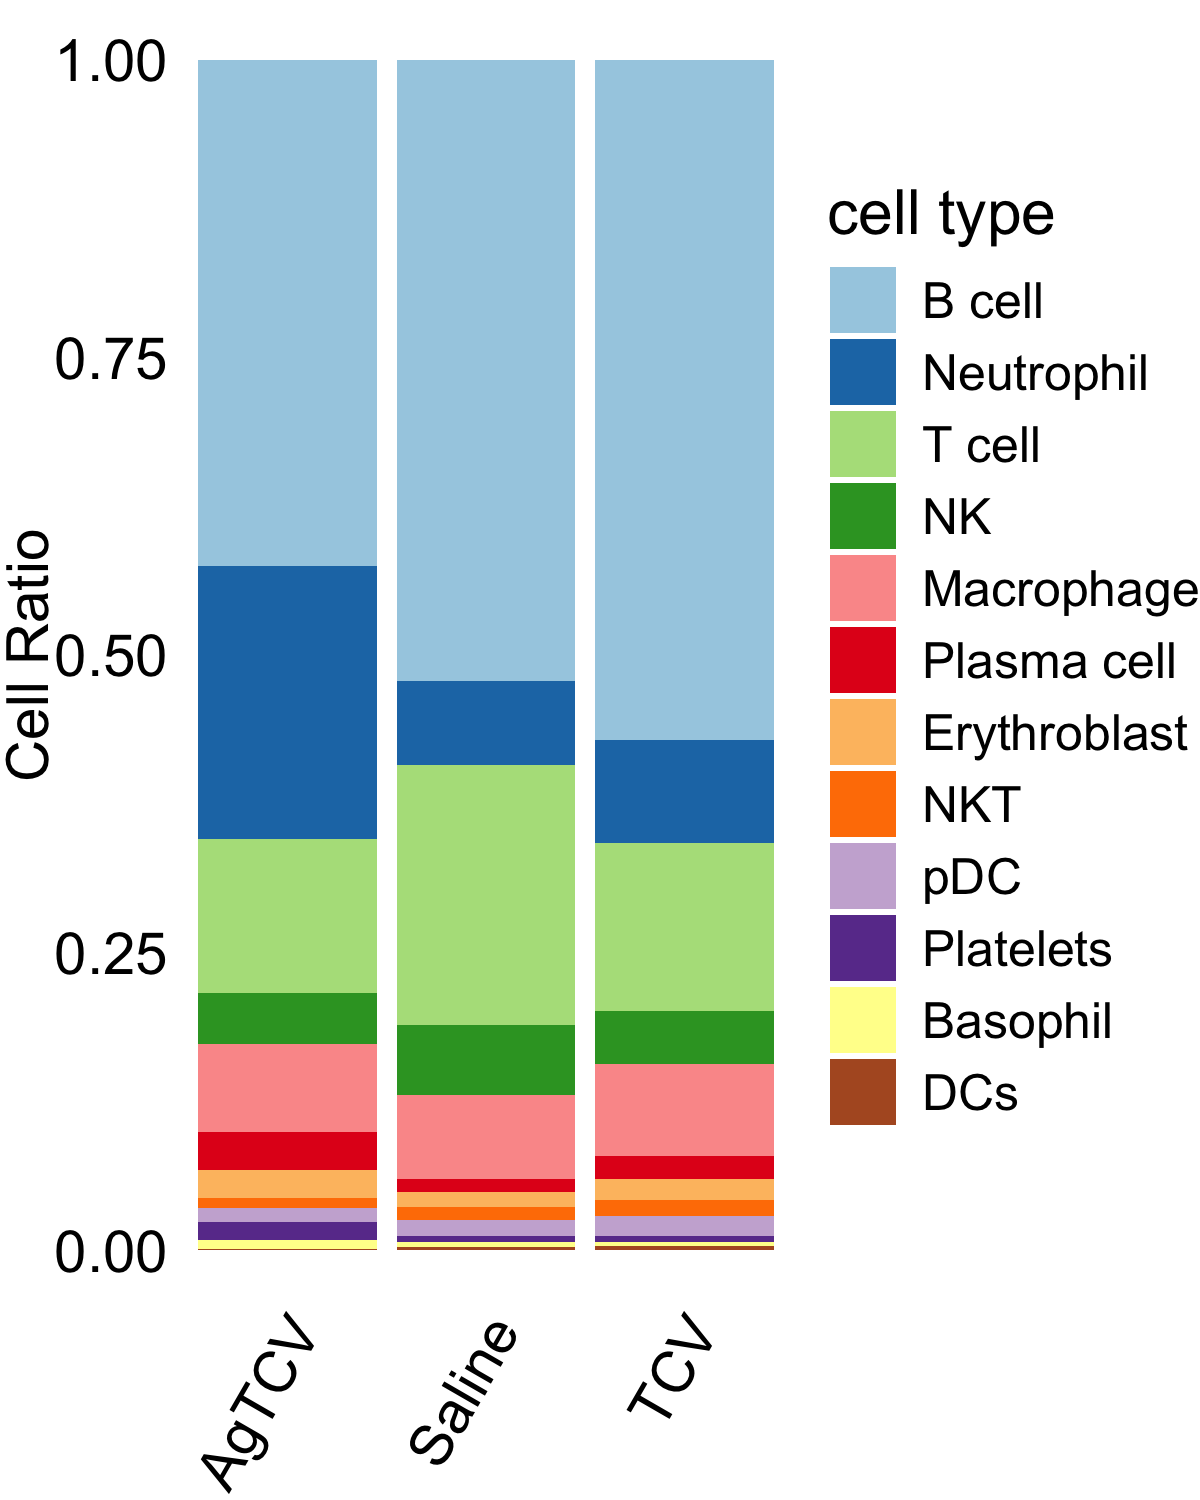

In [36]:
serat_meta <- seurat_integrated@meta.data
options(repr.plot.width = 4, repr.plot.height=5)
ggplot(serat_meta, aes(group,fill=Cell_Type_03))+ 
  xlab(NULL) + ylab("Cell Ratio") + theme_void() +   
  theme(legend.position = "right",
        axis.title.y = element_text(size = 14, angle = 90),
        axis.text.x = element_text(size=14, angle = 60, vjust = 1,hjust = 1),
        axis.text.y = element_text(size=14), legend.text = element_text(size=12),legend.title = element_text(size = 15)) + 
geom_bar(position = "fill")+ 
labs(fill = "cell type") + 
  scale_fill_manual(values=mycol) 

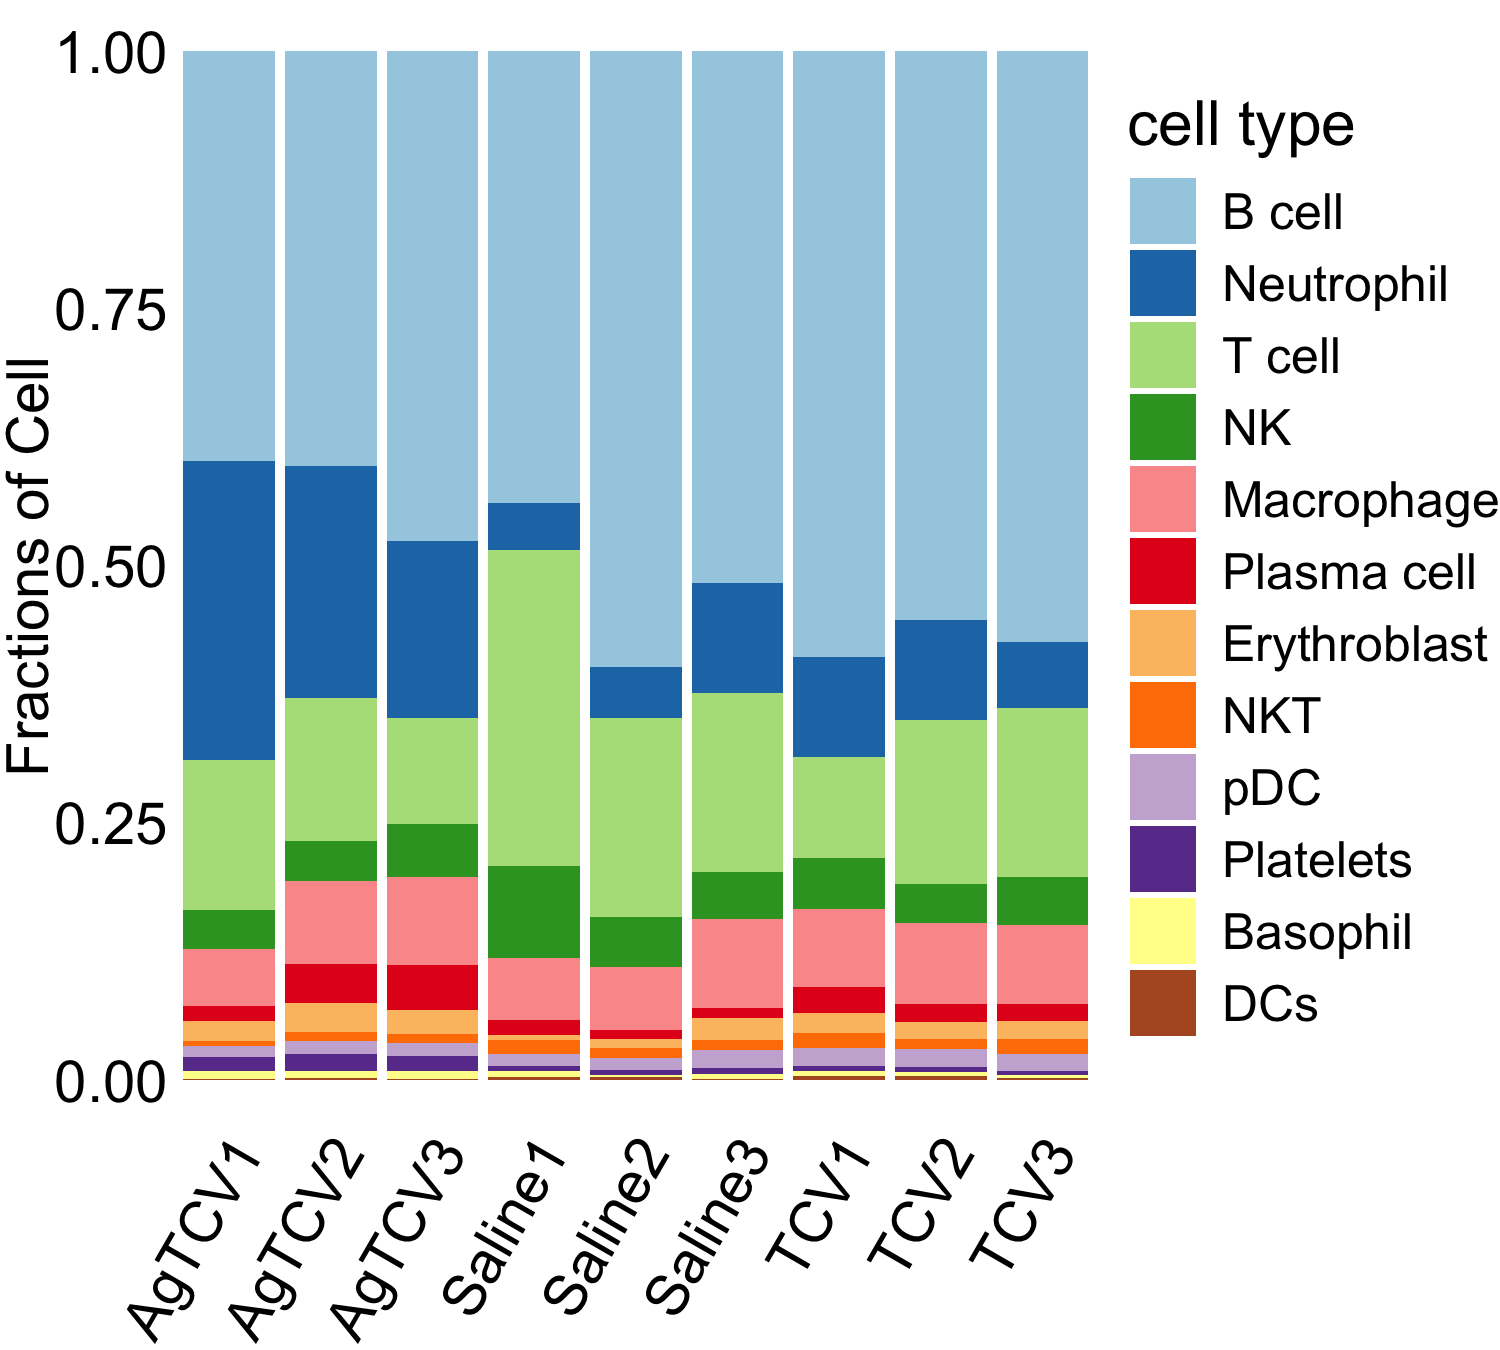

In [37]:
serat_meta <- seurat_integrated@meta.data
options(repr.plot.width = 5, repr.plot.height=4.5)
ggplot(serat_meta, aes(sample,fill=Cell_Type_03))+ 
  xlab(NULL) + ylab("Fractions of Cell") + theme_void() +   
  theme(legend.position = "right",
        axis.title.y = element_text(size = 14, angle = 90),
        axis.text.x = element_text(size=14, angle = 60, vjust = 1,hjust = 1),
        axis.text.y = element_text(size=14), legend.text = element_text(size=12),legend.title = element_text(size = 15)) + 
geom_bar(position = "fill")+ 
labs(fill = "cell type") + 
  scale_fill_manual(values=mycol) 

### Average heatmap

In [17]:
# anno_col <- pal_npg()(9)
anno_col <- mycol[1:12]
names(anno_col) <- levels(seurat_integrated$Cell_Type_03)

top.markers <- seurat_integrated.markers %>% group_by(cluster) %>% slice_max(n = 5, order_by = avg_log2FC)
###########################################
# get cells mean gene expression
mean_gene_exp <- AggregateExpression(object = seurat_integrated, group.by = c('Cell_Type_03'), features = unique(top.markers$gene))$RNA %>%
  data.frame() %>%
  as.matrix()
head(mean_gene_exp,2)


# add colnames
colnames(mean_gene_exp) <- levels(seurat_integrated$Cell_Type_03)

# Z-score
htdf <- t(scale(t(mean_gene_exp),scale = T,center = T))

# color
col_fun = colorRamp2(c(-2, 0, 2), c("#0099CC", "white", "#CC0033"))

# top annotation
column_ha = HeatmapAnnotation(cluster = colnames(htdf),
                              col = list(cluster = anno_col))

Warning message:
“The counts layer for the integrated assay is empty. Skipping assay.”


,B.cell,Neutrophil,T.cell,NK,Macrophage,Plasma.cell,Erythroblast,NKT,pDC,Platelets,Basophil,DCs
Fcer2a,34829,551,833,259,478,64,290,74,77,38,30,10
Cr2,51428,777,1087,296,836,105,336,101,105,27,56,13


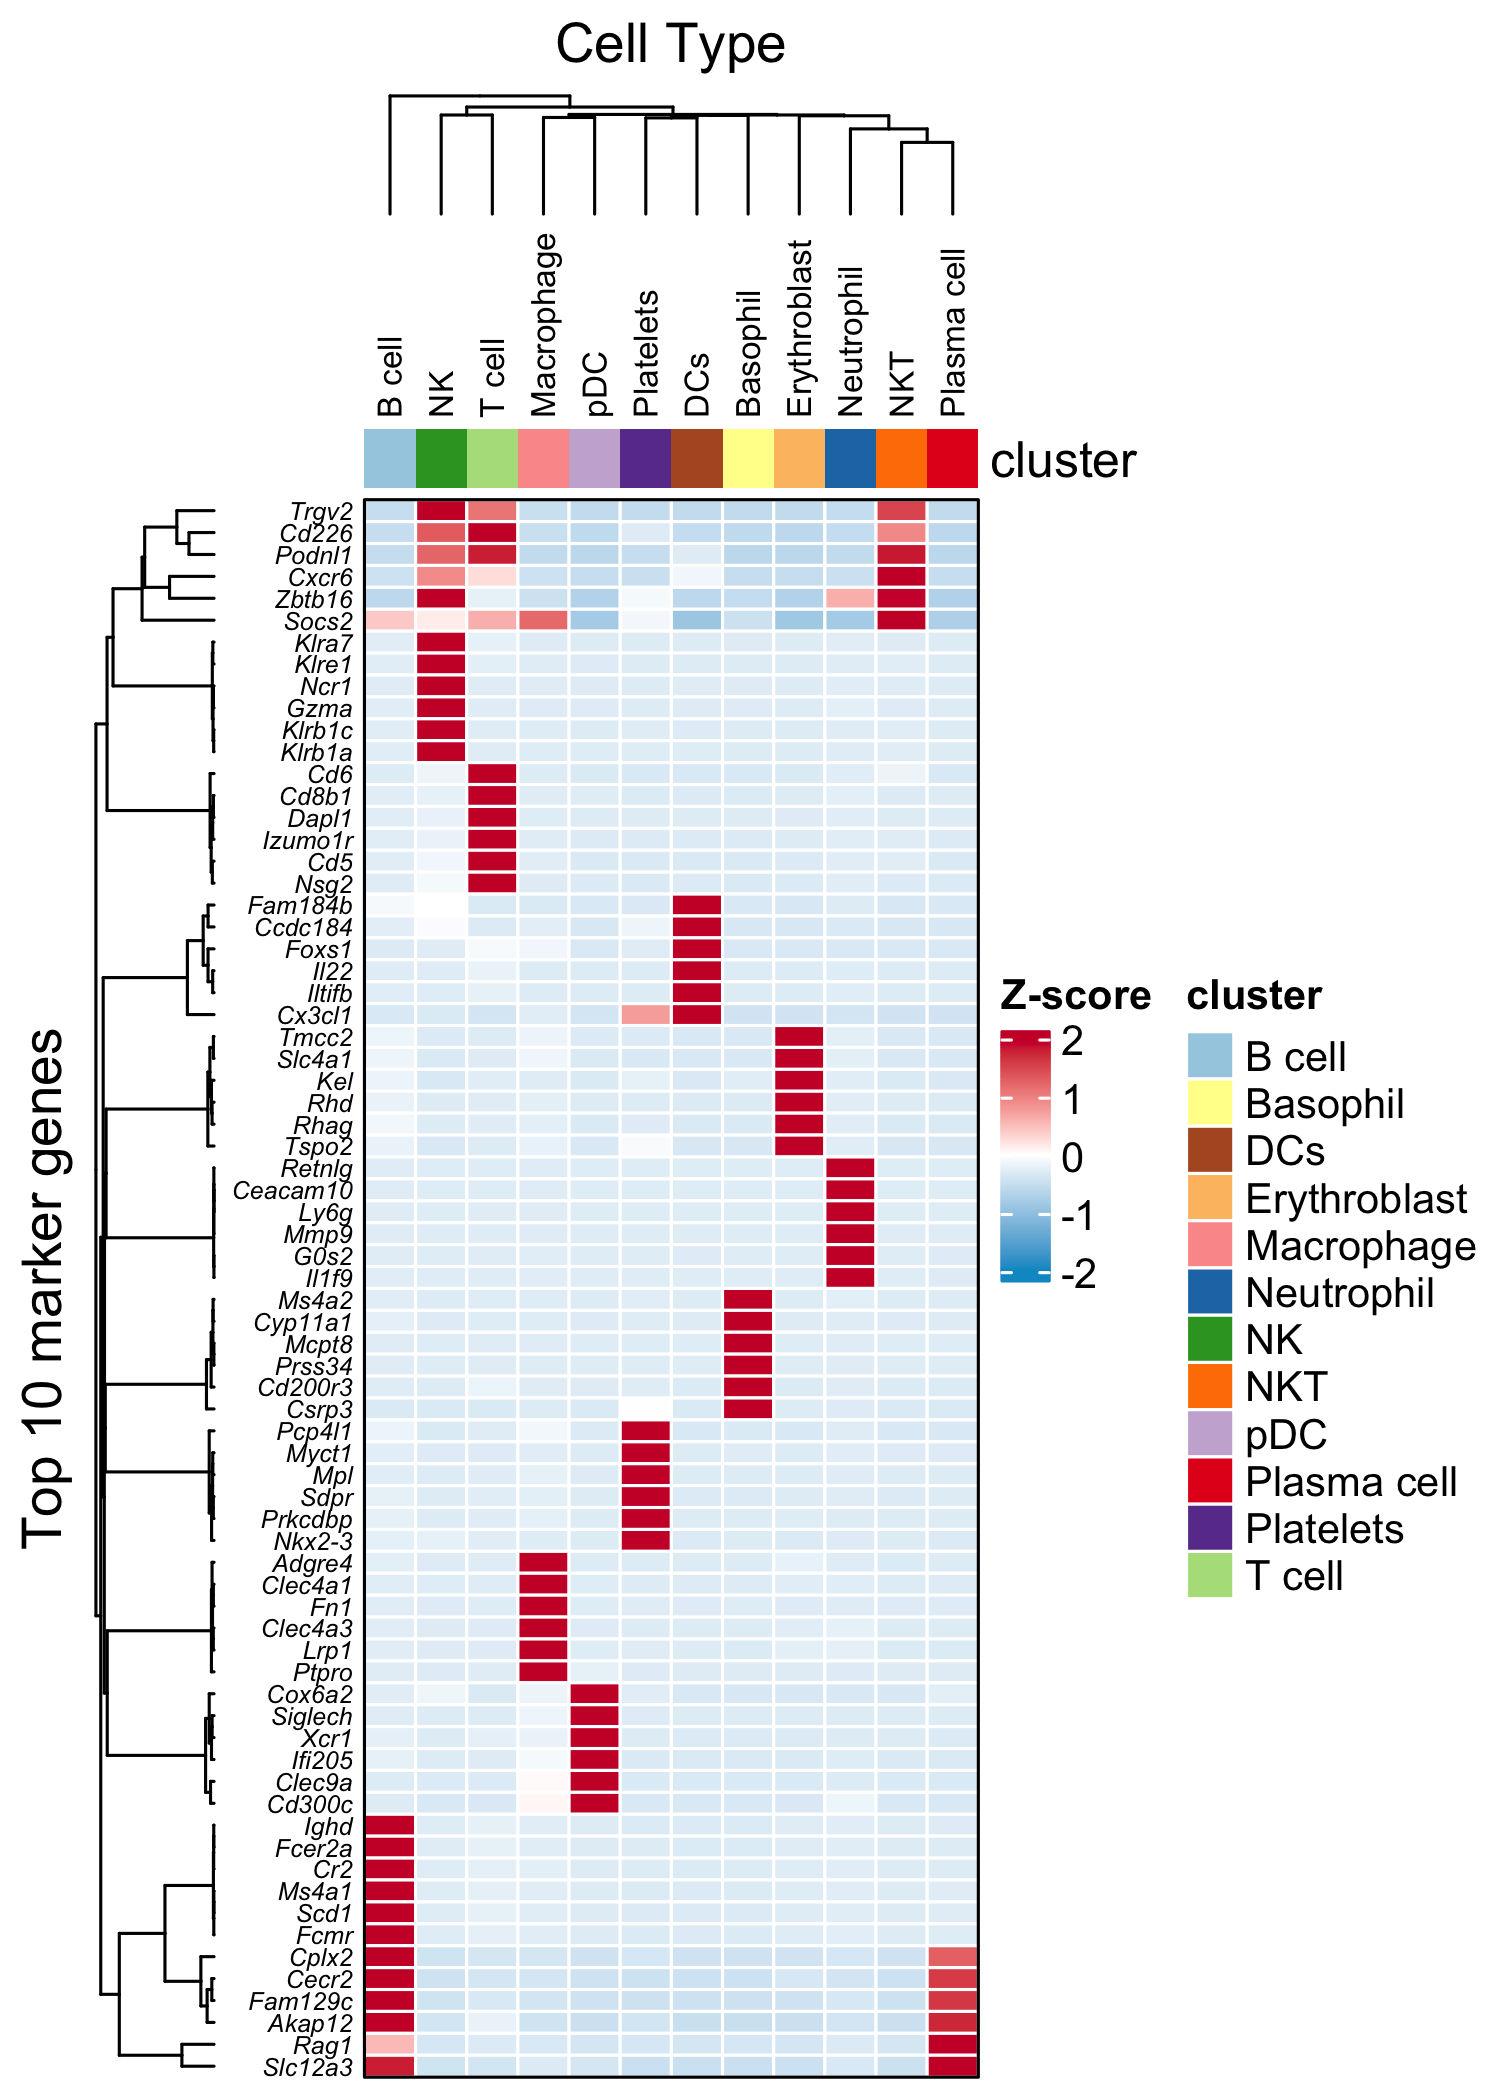

In [21]:
# plot the heatmap
options(repr.plot.height=7,repr.plot.width=5,repr.plot.res=300)

Heatmap(htdf,
        name = "Z-score",
        cluster_columns = T, cluster_rows = T,
        row_title = "Top 10 marker genes",
        column_title = "Cell Type",
        row_names_gp = gpar(fontface = 'italic',fontsize = 6),
        row_names_side = 'left',
        border = T,
        rect_gp = gpar(col = "white", lwd = 1),
        column_names_side = 'top',
        column_names_gp=gpar(fontsize=8),
        column_names_rot = 90,
        top_annotation = column_ha,
        # column_split = paste('clsuter ',0:41,sep = ''),
        col = col_fun)

### Dotplot-custome

In [43]:
x <- seurat_integrated.markers %>% group_by(cluster) %>% top_n(n = 5, wt = avg_log2FC)
options(repr.plot.width=15,repr.plot.height=5)

p <- DotPlot(seurat_integrated,
    features = split(x$gene, x$cluster),
    cols = c("#ffffff", "#448444")
    ) +
   RotatedAxis() + # 来自Seurat
    theme(
         panel.border = element_rect(color = "black"),
         panel.spacing = unit(1, "mm"),
         axis.title = element_blank(),
         axis.text.y = element_blank(),
     )

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


In [45]:
# 提取数据，使用ggplot2从头绘制：
p$data$feature.groups2 <- factor(p$data$feature.groups, 
    levels = c('B cell','Neutrophil','T cell','NK','Macrophage','Plasma cell','Erythroblast','NKT','pDC','Platelets','Basophil','DCs'))
library(ggh4x)
strip <- strip_themed(
    background_x = elem_list_rect(fill = brewer.pal(12, "Paired")))


Attaching package: ‘ggh4x’


The following object is masked from ‘package:ggplot2’:

    guide_axis_logticks




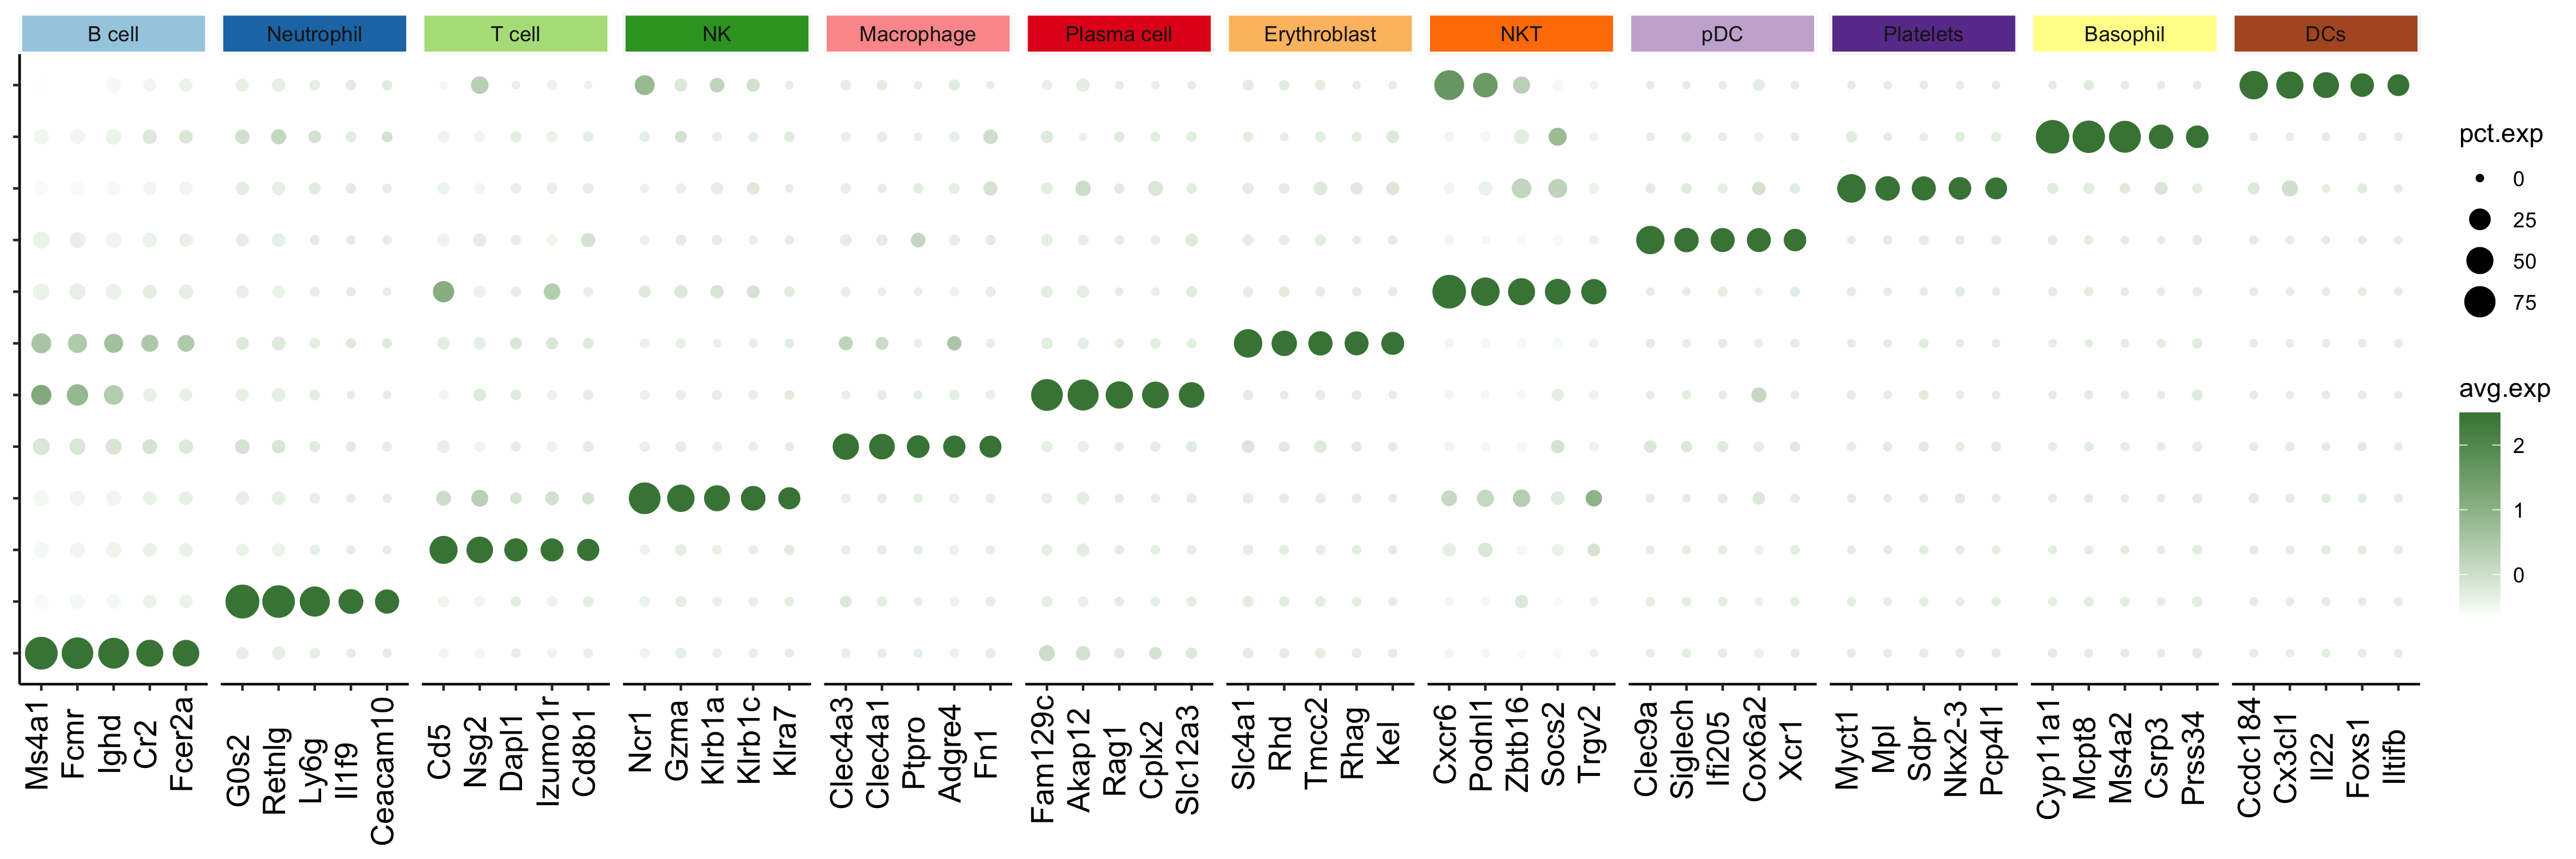

In [46]:
options(repr.plot.width=15,repr.plot.height=5)

p$data %>% 
    ggplot(aes(x = features.plot,
               y = id)) + 
    geom_point(aes(size = pct.exp, 
                   color = avg.exp.scaled)) + 
    facet_wrap2(~feature.groups2, 
                scales = "free_x", 
                strip = strip, 
                nrow = 1) + 
    theme_classic() + 
    theme(axis.text.x = element_text(angle = 90, size = 13,
                                     hjust = 0.5, 
                                     vjust = 0.3, 
                                     color = "black"),
          axis.title = element_blank(),
          strip.background = element_rect(color = "white"),
         # strip.text.x = element_text(size = 12, family = "Arial Narrow Bold"),
          axis.text.y = element_blank()
         ) + 
    scale_color_gradient(low = "#ffffff",
                         high = "#448444", 
                         name = "avg.exp") -> p
    
p

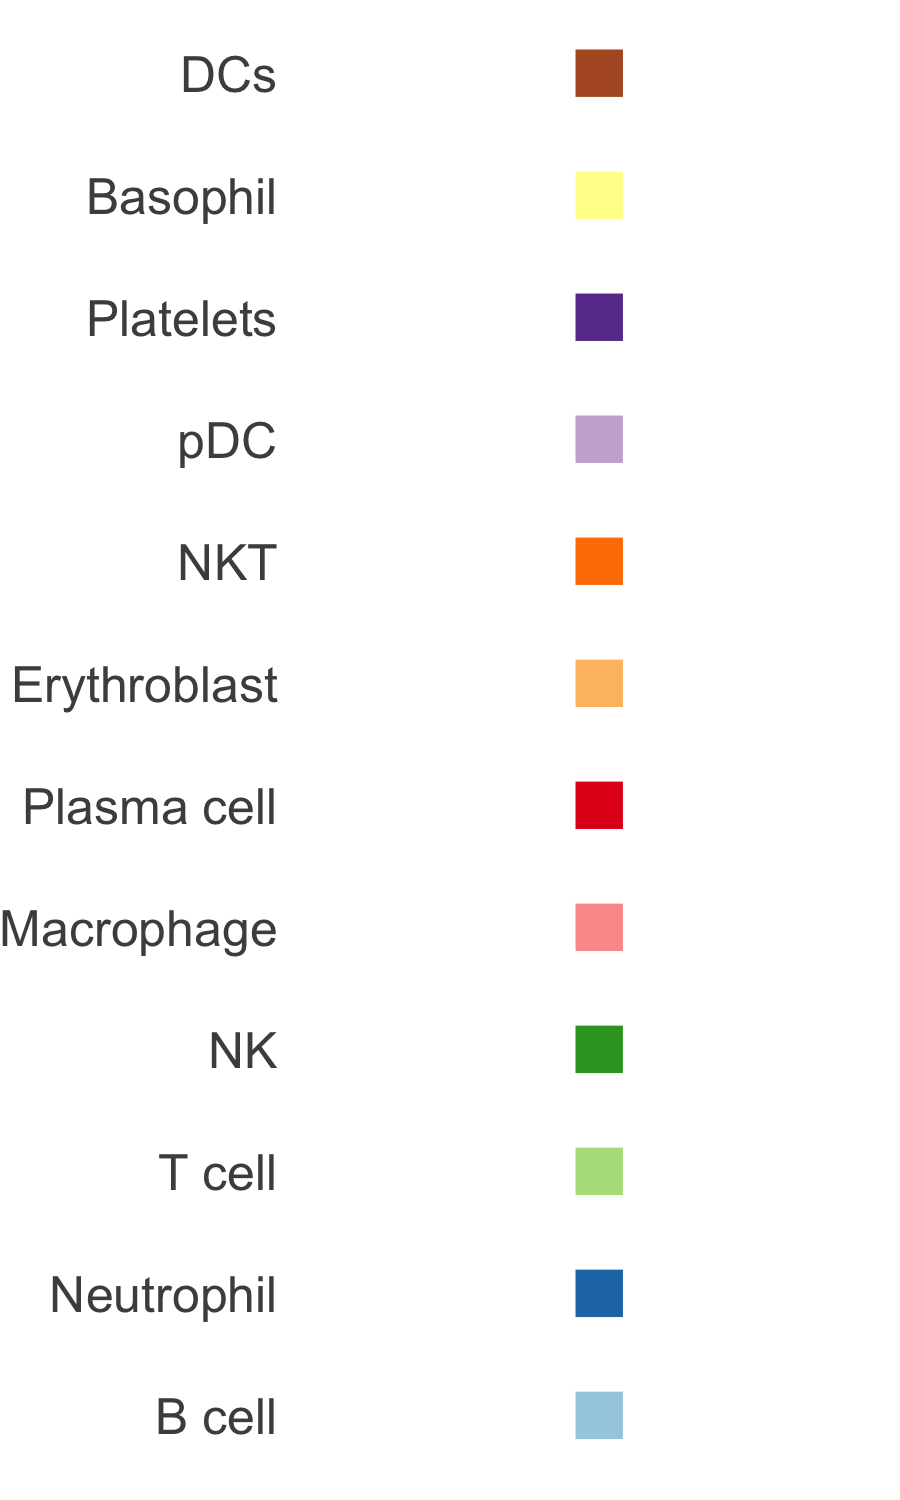

In [47]:
df <- data.frame(x = 0, y = levels(seurat_integrated), stringsAsFactors = F )
df$y <- factor(df$y, levels = df$y )
## 修改形状
pl2 <- ggplot(df, aes(x, y, color = factor(y))) +
    geom_point(size = 5, shape = 15, show.legend = F) +
    scale_color_manual(values = brewer.pal(12, "Paired")) +
    theme_classic() +
    scale_x_continuous(expand = c(0,0)) +
    theme(
        plot.margin = margin(r=0),
        axis.title = element_blank(),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 12),
        axis.ticks = element_blank(),
        axis.line = element_blank()
    )
options(repr.plot.width=3,repr.plot.height=5)

pl2

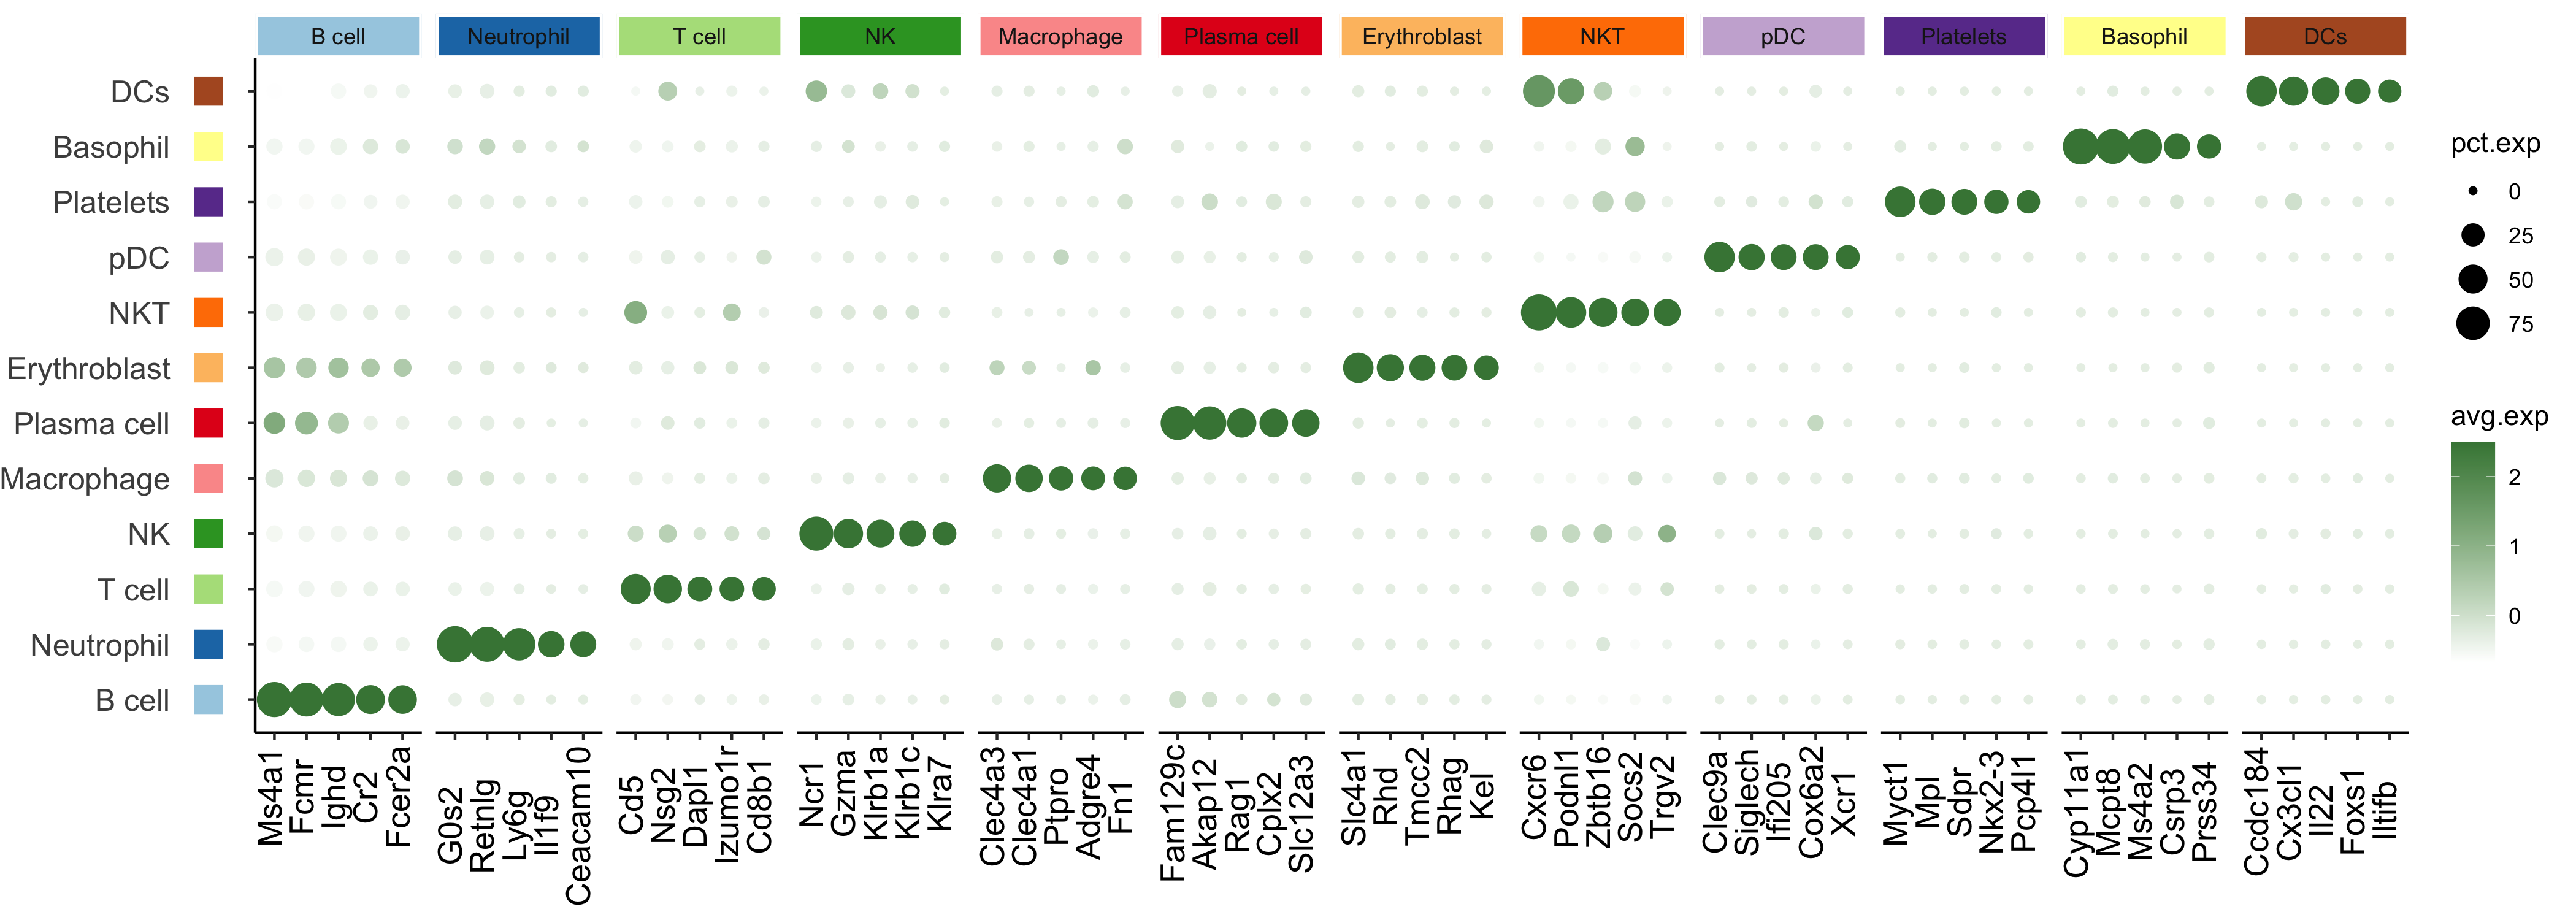

In [59]:
options(repr.plot.width=14,repr.plot.height=5, repr.plot.res=300)

plot_grid(pl2, p, align = "h", axis="bt", rel_widths = c(1, 10))